Project: Robo-Voice Synthesizer;
Authors: Aaren Arasaratnam, Jack Farlow;
Date: Aug. 1st, 2023 

In [148]:
# Importing libraries for entire project
import numpy as np
import pandas as pd
from scipy.signal import butter, sosfilt, resample, lfilter
from scipy.fft import fft, fftfreq
from scipy.io import wavfile
import matplotlib.pyplot as plt


In [149]:
# ======================
# Part A: The EMG Filter
# ======================

fs = 5000  # Sampling frequency (fs >= 2fmax = 2(450 Hz) = 900 Hz)
t = np.linspace(0, 5, int(fs * 2.048)) # Time vector; fs is 10240/10.24 = 1000

# ---------------------------
# A.3 Power Line Interference
# ---------------------------

f0 = 60  # Centre frequency
order = 2

notch = butter(order, [f0-0.5, f0+0.5], btype='bandstop', fs=fs, output='sos')  # 2nd-Order, Butterworth Notch Filter

# --------------------
# A.4 Background Noise
# --------------------

fl = 0.1
fh = 450

bpf = butter(order, [fl, fh], btype='bandpass', fs=fs, output='sos')  # 2nd-Order, Butterworth Bandpass Filter

# -------------
# A.5 Procedure
# -------------

# Importing .csv file containing raw EMG datasets
raw_relaxed = np.array(pd.read_csv('emg_data.csv', usecols=[0, 1]))
raw_contracted = np.array(pd.read_csv('emg_data.csv', usecols=[0, 2]))

# Applying filters to raw EMG datasets (notch, then bandpass)
filt_relaxed = sosfilt(bpf, sosfilt(notch, raw_relaxed))
filt_contracted = sosfilt(bpf, sosfilt(notch, raw_contracted))

# Computing FFTs for raw and filtered EMG datasets
N = len(raw_relaxed)

raw_relaxed_fft = (2/N) * np.abs(fft(raw_relaxed))
raw_contracted_fft = (2/N) * np.abs(fft(raw_contracted))
filt_relaxed_fft = (2/N) * np.abs(fft(filt_relaxed))
filt_contracted_fft = (2/N) * np.abs(fft(filt_contracted))

# Truncating FFTs to only include positive frequencies
t_fft = fftfreq(N, 1/fs) # ts = 1/fs = 1/(1000) = 0.001

t_fft = t_fft[0:N//2]
raw_relaxed_fft = raw_relaxed_fft[0:N//2]
raw_contracted_fft = raw_contracted_fft[0:N//2] 
filt_relaxed_fft = filt_relaxed_fft[0:N//2]
filt_contracted_fft = filt_contracted_fft[0:N//2]


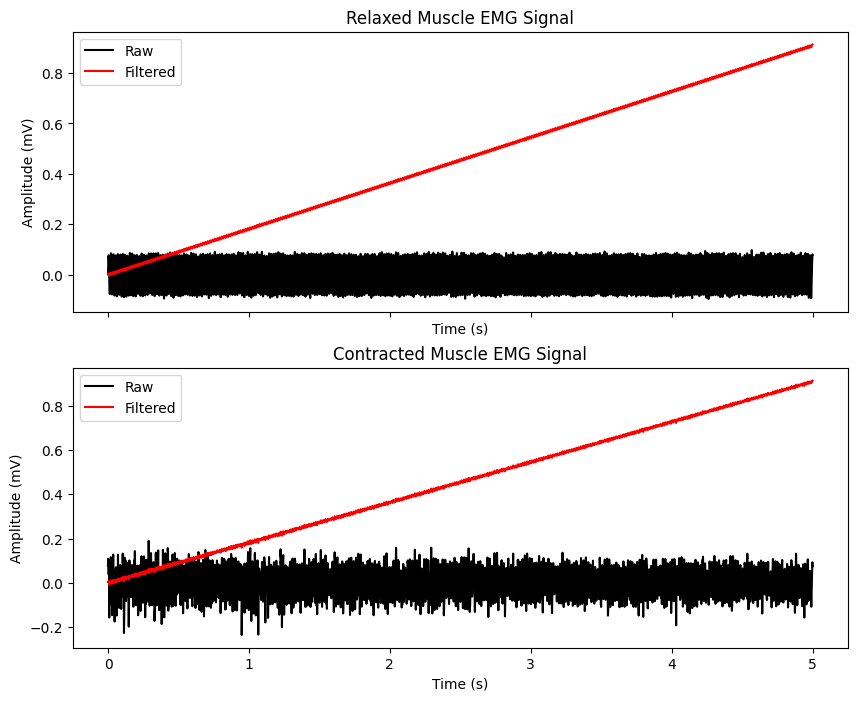

In [150]:
# Plotting in time domain
'''
*Note: I'm not sure why there's a positive slope with the filtered signal plots, but it seemingly has to do with the bandpass, since I tested both separately and the notch seems to work fine on its own. Sadly, we couldn't find a fix in time, but we'll keep working on it on the side.
'''
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.plot(t, raw_relaxed[:, 1], 'black', label='Raw')
ax1.plot(t, filt_relaxed[:, 1], 'red', label='Filtered')
ax1.set_title('Relaxed Muscle EMG Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (mV)')
ax1.legend()

ax2.plot(t, raw_contracted[:, 1], 'black', label='Raw')
ax2.plot(t, filt_contracted[:, 1], 'red', label='Filtered')
ax2.set_title('Contracted Muscle EMG Signal')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude (mV)')
ax2.legend()


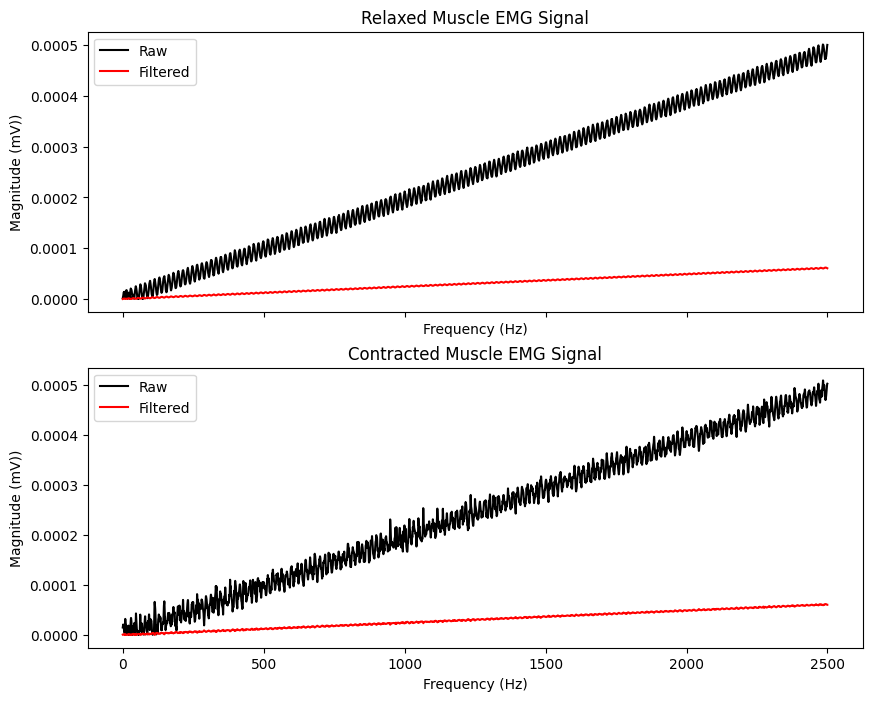

In [151]:
# Plotting spectrum
'''
*Note: We believe these graphs are messed up because the prior time-domain graphs are likewise messed up.
'''
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax1.plot(t_fft, raw_relaxed_fft[:, 1], 'black', label='Raw')
ax1.plot(t_fft, filt_relaxed_fft[:, 1], 'red', label='Filtered')
ax1.set_title('Relaxed Muscle EMG Signal')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (mV))')
ax1.legend()

ax2.plot(t_fft, raw_contracted_fft[:, 1], 'black', label='Raw')
ax2.plot(t_fft, filt_contracted_fft[:, 1], 'red', label='Filtered')
ax2.set_title('Contracted Muscle EMG Signal')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude (mV))')
ax2.legend()


In [152]:
# Finding RMS (in time domain)
raw_relaxed_rms = np.sqrt(np.mean(np.square(raw_relaxed)))
raw_contracted_rms = np.sqrt(np.mean(np.square(raw_contracted)))
filt_relaxed_rms = np.sqrt(np.mean(np.square(filt_relaxed)))
filt_contracted_rms = np.sqrt(np.mean(np.square(filt_contracted)))

raw_relaxed_rms, raw_contracted_rms, filt_relaxed_rms, filt_contracted_rms # Output: 2.04..., 2.04..., 0.388..., 0.388...

(2.041686414152029, 2.041800813056388, 0.38835106454274493, 0.3883529877707831)

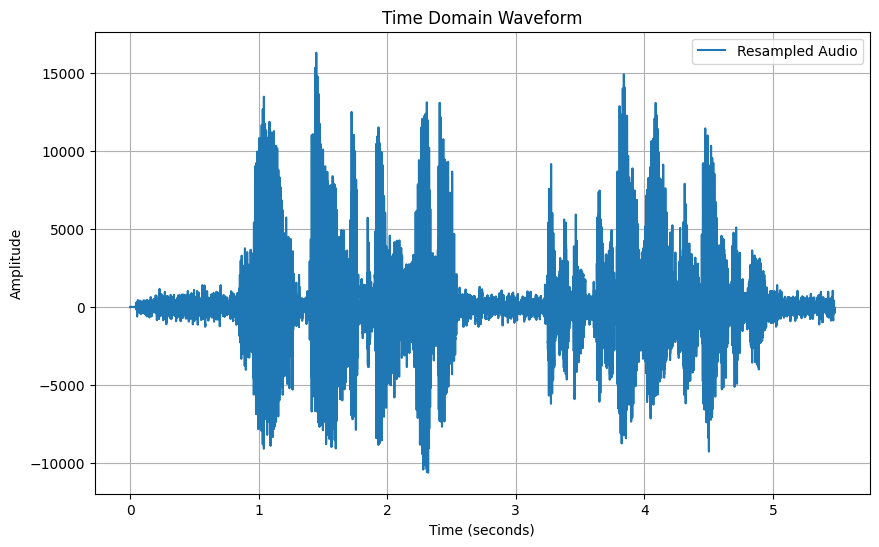

In [153]:
# ==============================
# Part B: Robo-Voice Synthesizer
# ==============================

# -----------------
# B.2 Preprocessing
# -----------------

fs, audio = wavfile.read('quote.wav')
fs # Output: 44.1 kHz

# Downsampling to 16 kHz
resampled_audio = resample(audio, int(len(audio) * 16000/fs)).astype(np.int16)
wavfile.write('quote_resampled.wav', 16000, resampled_audio)

t_resampled = np.linspace(0, len(resampled_audio)/16000, len(resampled_audio))

# Plotting time stream
plt.figure(figsize=(10, 6))
plt.plot(t_resampled, resampled_audio, label='Resampled Audio')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Time Domain Waveform')
plt.legend()
plt.grid()
plt.show()


In [154]:
# -------------
# B.3 Procedure
# -------------

# .................
# Time Segmentation
# .................

def divide_into_chunks(data, chunk_size, overlap):
    num_chunks = (len(data) - chunk_size) // (chunk_size - overlap) + 1
    chunks = []
    
    for i in range(num_chunks):
        start = i * (chunk_size - overlap)
        end = start + chunk_size
        chunk = data[start:end]
        chunks.append(chunk)
    
    return chunks

audio_chunks = divide_into_chunks(resampled_audio, int(12.5 * fs/1000), int(0.05 * fs/1000))

# .........................
# Frequency Domain Analysis
# .........................

# # of BPFs
N = 10

# Define the parameters for the bank of BPFs
order = 4
fs = 16000  # Sampling frequency in Hz
bw = 75  # Bandwidth for each BPF in Hz
centre_frequencies = np.linspace(200, 2000, N)  # centre frequencies of BPFs

# Initialize an empty list to store filtered chunks
filtered_chunks = []

# Apply bank of BPFs to each chunk
for chunk in audio_chunks:
    filtered_chunk = np.zeros_like(chunk, dtype=np.int16)
    
    for centre_frequency in centre_frequencies:
        # Design BPF
        fl = centre_frequency - bw / 2
        fh = centre_frequency + bw / 2
        b, a = butter(order, [fl, fh], btype='bandpass', fs=fs)
        
        # Apply filter to chunk
        filtered_chunk += lfilter(b, a, chunk).astype(np.int16)
    
    # Append filtered chunk to list
    filtered_chunks.append(filtered_chunk)

# Convert list of filtered chunks back to array
filtered_data = np.concatenate(filtered_chunks)

# Increasing final volume by 2.5x
amplified_filtered_data = (filtered_data * 2.5)

wavfile.write('quote_filtered.wav', fs, amplified_filtered_data.astype(np.int16))


In [155]:
# .........
# Synthesis
# .........

# Initialize empty list to store synthesized chunks
synthesized_chunks = []

# Synthesize and superimpose sine waves for each band
for chunk in audio_chunks:
    total_synth_wave = np.zeros_like(chunk, dtype=np.float32)
    
    for i, centre_frequency in enumerate(centre_frequencies):
        fl = centre_frequency - bw / 2
        fh = centre_frequency + bw / 2
        b, a = butter(order, [fl, fh], btype='bandpass', fs=fs)
        filtered_chunk = lfilter(b, a, chunk)
        rms_val = np.sqrt(np.mean(np.square(filtered_chunk)))
        
        # Create time array for chunk duration
        t_chunk = np.linspace(0, len(chunk)/fs, len(chunk), endpoint=False)

        # Synthesize sine wave using RMS value as amplitude
        synth_wave = rms_val * np.sin(2 * np.pi * centre_frequency * t_chunk)
        total_synth_wave += synth_wave[:len(chunk)] # Ensure lengths match
    
    # Append synthesized chunk to list
    synthesized_chunks.append(total_synth_wave)

# Convert list of synthesized chunks back to array
synthesized_data = np.concatenate(synthesized_chunks)

# Increasing final volume by 1.5x
amplified_synthesized_data = (synthesized_data * 1.5)

wavfile.write('quote_synthesized.wav', fs, amplified_synthesized_data.astype(np.int16))



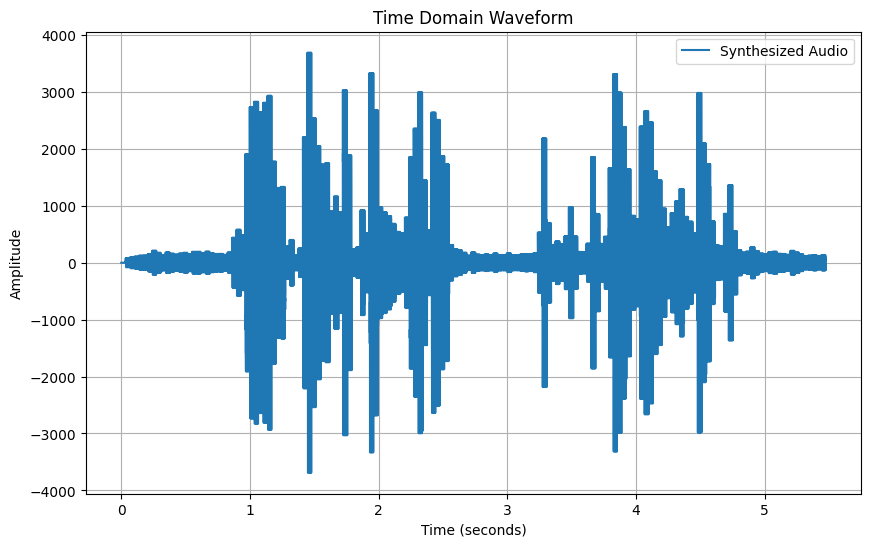

In [157]:
# ----------------------
# B.4 Evaluate your work
# ----------------------

t_synthesized = np.linspace(0, len(synthesized_data) / fs, len(synthesized_data), endpoint=False)

# Plotting output
plt.figure(figsize=(10, 6))
plt.plot(t_synthesized, synthesized_data, label='Synthesized Audio')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Time Domain Waveform')
plt.legend()
plt.grid()
plt.show()
